In [3]:
import matplotlib.pyplot as plt
from utils import patch_generator, supres_generator, Segmentation

tif_10m='demo/sent2020_10m.tif'
tif_20m='demo/sent2020_20m.tif'
s1tif_20m='demo/landusing18_20_1b.tif'
# vectors="zip:///home/sgr/Загрузки/test_poly.zip"
vectors="zip://demo/test_poly.zip"

init_params={'tif_10m':tif_10m,'tif_20m':tif_20m,'vectors':vectors,'s1tif_20m':s1tif_20m}

In [5]:
next_item=patch_generator(init_params)
items=[]
for i in range(14):
    items.append(next(next_item))

In [3]:
items.sort(key=(lambda it: it['patch_10'].shape[1]*it['patch_10'].shape[2]))

In [7]:
next_super=supres_generator(items)
super_items=[]
for i in range(14):
    super_items.append(next(next_super))

In [8]:
# segm_class=Segmentation(line_thresh=0.02,area_thresh=16)
# segm_class=Segmentation(line_thresh=0.005,area_thresh=48)
segm_class=Segmentation(line_thresh=0.002,area_thresh=96)
next_segment=segm_class.segm_map_generator(super_items)
segment_items=[]
for i in range(14):
    segment_items.append(next(next_segment))

/home/sgr/Загрузки/PIKVNZ/model/COBresolve.py:105: RuntimeWarning: invalid value encountered in true_divide
  O=(np.sum(ab*w1w2,axis=0)/np.sum((ab>0)*w1w2,axis=0)*((ind1*ind2==0)+(abs(ind1-ind2)==1))-1)*np.pi/numClusters


In [63]:
segment_items[0].keys()

dict_keys(['patch_10', 'patch_20', 'rgb_10', 'geojson', 'transf_10', 'transf_20', 'crs', 'rgb_5', 'transf_5', 'segments_5'])

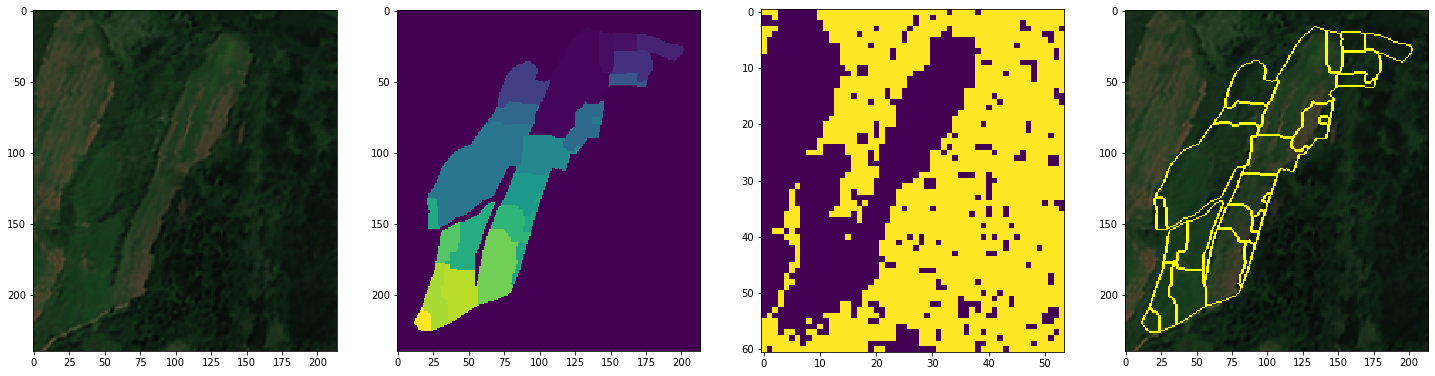

In [9]:
from skimage.segmentation import mark_boundaries
nm=0
plt.figure(figsize=(25,20))
plt.subplot(1,4,1)
plt.imshow(segment_items[nm]['rgb_5'])
plt.subplot(1,4,2)
plt.imshow(segment_items[nm]['segments_5'])
plt.subplot(1,4,3)
plt.imshow(segment_items[nm]['patchs1_20'])
plt.subplot(1,4,4)
plt.imshow(mark_boundaries(segment_items[nm]['rgb_5'], segment_items[nm]['segments_5']))

In [10]:
import pickle
rf_model_path='./model/RF_model.pkl'
with open(rf_model_path, 'rb') as f:
    clf=pickle.load(f)
    print(clf.predict([[0,0,10,30,20,40,80,60,80,100]]))

[4]


/home/sgr/miniconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/sgr/miniconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [17]:
import numpy as np
import scipy
nm=10
param_dict=segment_items[nm]

def simple_rescale(im, scf=2):
    row,col=im.shape[0],im.shape[1]
    return np.array([[im[int(r/scf)][int(c/scf)] for c in range(col*scf)] for r in range(row*scf)])

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
@interact
def get_by_num(numb=(0,len(segment_items)-1,1)):#numb=range(14)):
    
    nm=int(numb)
    param_dict=segment_items[nm]
    segm=param_dict['segments_5']
    transf_10=param_dict['transf_10']
    transf_20=param_dict['transf_20']
    patch_10=np.rollaxis(param_dict['patch_10'],0,3)
    patch_20=np.rollaxis(param_dict['patch_20'],0,3)
    patchs1_20=param_dict['patchs1_20']


    x10,y10,_=patch_10.shape
    y_sh,x_sh=np.abs(np.array([transf_10,transf_20]).T.dot(np.array([-1,1]))[[2,5]]/10).astype(int)
    patch_20to10=simple_rescale(patch_20)[x_sh:x_sh+x10,y_sh:y_sh+y10,:]
    feat_image=simple_rescale(np.concatenate((patch_10, patch_20to10), axis=2))


    patchs1_20to10=simple_rescale(patchs1_20)[x_sh:x_sh+x10,y_sh:y_sh+y10]
    patchs1_5=simple_rescale(patchs1_20to10)    #sent1 5m patch

    remap={}
    for index in np.unique(segm.ravel()):
        if index==0: continue        
        nm_pix=len(segm[segm==index])//4
    #     nm_samples=np.ceil((np.log(nm_pix)/np.log(2))**1.6).astype(int) 
        nm_samples=nm_pix

        id_choises=np.random.choice(range(nm_pix),nm_samples,replace=False)    
        is_candidate=(patchs1_5[segm==index].mean()+0.51).astype(int)
    #     is_candidate=(patchs1_5[segm==index][id_choises].mean()+0.6).astype(int)
        if not is_candidate:
            remap[index]=0
            continue   

    #     featured_items=feat_image[segm==index][id_choises]
        featured_items=feat_image[segm==index]
        cl=scipy.stats.mode(sorted(clf.predict(featured_items))).mode[0]
        remap[index]=cl
    src, values = remap.keys(), remap.values()
    d_array = np.arange(segm.max() + 1)
    d_array[list(src)] = list(values)
    class_image=d_array[segm]  

    from matplotlib.colors import LinearSegmentedColormap
    colors = [(0, 0, 0), (0.1,0.1,0.1), (1, 0, 0),(0, 1, 0), (0, 0, 1)]  # R -> G -> B
    n_bins = 5  # Discretizes the interpolation into bins
    cmap_name = 'my_list'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)



    plt.figure(figsize=(25,20))
    plt.subplot(1,3,1)
    plt.imshow(mark_boundaries(param_dict['rgb_5'], segm))
    plt.subplot(1,3,2)
    class_image[segm==0]=-1
    class_image[0,0]=1
    class_image[0,0]=2
    class_image[0,0]=3
    class_image[0,0]=4  
    
    
    plt.imshow(class_image,cmap=cm)
    
    print(np.unique(class_image,return_counts=True))

    plt.subplot(1,3,3)
    x,y,b=feat_image.shape
    pix_cl_masked=clf.predict(feat_image.reshape((x*y,b))).reshape((x,y))*(patchs1_5!=0)*(segm!=0)
    pix_cl_masked[segm==0]=-1
    
    pix_cl_masked[0,0]=1
    pix_cl_masked[0,0]=2
    pix_cl_masked[0,0]=3
    pix_cl_masked[0,0]=4
    
    plt.imshow(pix_cl_masked,cmap=cm)



interactive(children=(IntSlider(value=6, description='numb', max=13), Output()), _dom_classes=('widget-interac…

In [18]:
# COMMENT

In [ ]:
plt.imshow(segment_items[13]['patchs1_20'])

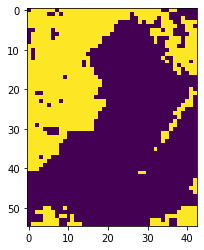

In [71]:
plt.imshow(segment_items[13]['patchs1_20'])

Text(0.5, 1.0, '(109, 85, 6)')

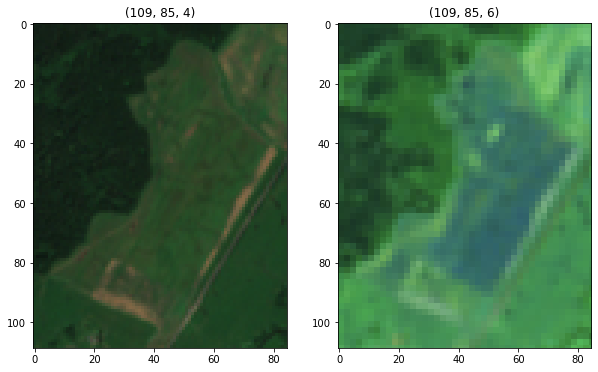

In [316]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(p10[:,:,[2,1,0]]/2500)
plt.title(p10.shape)
plt.subplot(1,2,2)
plt.imshow(p20_res[:,:,[5,4,0]]/3000)
plt.title(p20_res.shape)

In [203]:
v=np.array([1,5,2])
scale(p20,2)[10,50,:],p20[5,25,:]

(array([ 935, 3065, 3923, 4107, 1788,  815], dtype=uint16),
 array([ 935, 3065, 3923, 4107, 1788,  815], dtype=uint16))